# Peter og ulven: Realistisk miljø

I vår situasjon kunne Peter bevege seg rundt nesten uten å bli sliten eller sulten. I en mer realistisk verden må han sette seg ned og hvile fra tid til annen, og også sørge for å spise. La oss gjøre verden mer realistisk ved å implementere følgende regler:

1. Når Peter beveger seg fra ett sted til et annet, mister han **energi** og blir mer **sliten**.
2. Peter kan få mer energi ved å spise epler.
3. Peter kan kvitte seg med tretthet ved å hvile under et tre eller på gresset (dvs. gå til et felt med et tre eller gress - grønt felt).
4. Peter må finne og drepe ulven.
5. For å kunne drepe ulven, må Peter ha visse nivåer av energi og tretthet, ellers taper han kampen.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

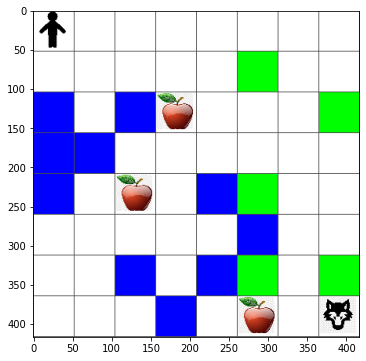

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Definere tilstand

I våre nye spilleregler må vi holde oversikt over energi og tretthet i hver bretttilstand. Derfor vil vi opprette et objekt `state` som vil inneholde all nødvendig informasjon om nåværende problemtilstand, inkludert tilstanden til brettet, nåværende nivåer av energi og tretthet, og om vi kan beseire ulven når vi er i terminaltilstand:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Belønningsfunksjon

En belønningsfunksjon er en nøkkelkomponent i forsterkende læring. Den definerer målet for agenten ved å tildele en numerisk verdi, kalt belønning, til hver handling eller sekvens av handlinger som agenten utfører.

### Hvordan fungerer en belønningsfunksjon?

Belønningsfunksjonen fungerer som en veiledning for agenten. Den gir tilbakemelding på hvor godt agentens handlinger samsvarer med det ønskede målet. For eksempel:

- Hvis agenten utfører en handling som bringer den nærmere målet, kan belønningsfunksjonen gi en positiv verdi.
- Hvis agenten utfører en handling som fører til et uønsket resultat, kan belønningsfunksjonen gi en negativ verdi.

### Design av en effektiv belønningsfunksjon

Å designe en god belønningsfunksjon er avgjørende for å sikre at agenten lærer riktig oppførsel. Her er noen viktige punkter å huske på:

1. **Klarhet og enkelhet**: Belønningsfunksjonen bør være enkel nok til at agenten kan forstå hva som forventes.
2. **Unngå utilsiktede insentiver**: Sørg for at belønningsfunksjonen ikke oppmuntrer til uønsket oppførsel.
3. **Balansere kortsiktige og langsiktige mål**: Belønningsfunksjonen bør ta hensyn til både umiddelbare og fremtidige gevinster.

### Eksempel på en belønningsfunksjon

Her er et eksempel på en enkel belønningsfunksjon:

```python
def reward_function(state, action):
    if action == "move_towards_goal":
        return 10  # Positiv belønning
    elif action == "move_away_from_goal":
        return -10  # Negativ belønning
    else:
        return 0  # Nøytral belønning
```

I dette eksemplet får agenten en positiv belønning for å bevege seg mot målet, en negativ belønning for å bevege seg bort fra målet, og ingen belønning for nøytrale handlinger.

### Vanlige utfordringer

- **Belønningsmanipulering**: Agenten kan finne måter å "spille systemet" på ved å maksimere belønningen uten å oppnå det egentlige målet.
- **Sparsomme belønninger**: Hvis belønningene er for sjeldne, kan det være vanskelig for agenten å lære.
- **Overoptimalisering**: En for spesifikk belønningsfunksjon kan føre til at agenten overfokuserer på én oppgave og ignorerer andre viktige aspekter.

### Oppsummering

En godt designet belønningsfunksjon er avgjørende for å trene en effektiv forsterkende læringsagent. Den bør være balansert, tydelig og fri for utilsiktede insentiver. Ved å forstå og adressere vanlige utfordringer kan du lage en belønningsfunksjon som hjelper agenten med å lære ønsket oppførsel.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Læringsalgoritme

Selve læringsalgoritmen forblir stort sett uendret, vi bruker bare `state` i stedet for kun brettposisjon.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

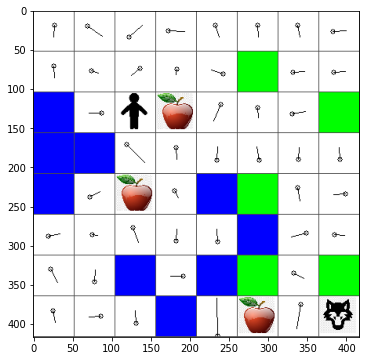

In [11]:
m.plot(Q)

## Resultater

La oss se om vi klarte å trene Peter til å kjempe mot ulven!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Vi ser nå mye færre tilfeller av drukning, men Peter klarer fortsatt ikke alltid å drepe ulven. Prøv å eksperimentere og se om du kan forbedre dette resultatet ved å justere hyperparametere.


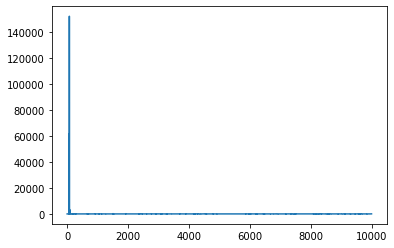

In [13]:
plt.plot(lpath)


---

**Ansvarsfraskrivelse**:  
Dette dokumentet er oversatt ved hjelp av AI-oversettelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selv om vi tilstreber nøyaktighet, vennligst vær oppmerksom på at automatiske oversettelser kan inneholde feil eller unøyaktigheter. Det originale dokumentet på sitt opprinnelige språk bør anses som den autoritative kilden. For kritisk informasjon anbefales profesjonell menneskelig oversettelse. Vi er ikke ansvarlige for eventuelle misforståelser eller feiltolkninger som oppstår ved bruk av denne oversettelsen.
